# LR

### Imports

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from ppvm_py.utils import load_object
from ppvm_py.utils import zero_smallest_absolute_to_meet_ratio


from ppvm_py.plotting import plot_timeseries
from ppvm_py.plotting import plot_heatmap
from ppvm_py.plotting import generate_2d_video
from ppvm_py.plotting import plot_histogram

from ppvm_py.data_processing.patt_fld8v import print_xyz_slice_example_from_parsed_data

from ppvm_py.data_processing.utils import generate_coord_nd
from ppvm_py.data_processing.utils import create_index_to_coord_map

from ppvm_py.feature_generation.sdc import compute_symmetric_difference_coefficients_with_index_to_coord_map

from ppvm_py.data_utils_3d import find_closest_coordinate_index

### General Args

In [2]:
# IMPORTANT: Restart Kernel when swapping datasets to reload them!
Ha = 300

if Ha == 300:
    patt_fld8v_folder_path = Path("../../../../../data/4pi_re1000_ha300.360_ch28.p1/patt_fld8v/")
elif Ha == 1000:
    patt_fld8v_folder_path = Path("../../../../../data/4pi_re1000_ha1000.384.pi/patt_fld8v/")

fld_path = patt_fld8v_folder_path / Path("pkl/patt_fld8v.pkl")

# Estimates from evaluations
sigma = -1  # According to the results here.
B_z = -1  # According to the results here.

animation_folder = Path(f"../output/animations/spacetime_window/")

truncate_data = False
truncate_at_snapshot = 20  # Including indices 0 to (truncate_at_snapshot - 1)

test_size = 0.3

input_window_shape = (3, 3, 3, 3)  # n_idx of (time, x, y, z) including center index.

regularization_weight = 1.0

##### Define output_indices

In [3]:
# SELECT ONE:
# 1: (1.5, 0, 0)
# 2: (8, 0, 0)
# ...
# (x, y, z) in [0, 12.56637] x [-1, 1] x [-1, 1]
location = 1

# When closest coordinates are not determined yet.
# Note: if 'True' is set for the first time, kernel must be restarted.
find_closest_coordinates = False

In [4]:
if location == 1:
    x_coord_desired = 1.5
    y_coord_desired = 0
    z_coord_desired = 0
    # closest available grid locations for desired ones have to be determined further below after data loading

    # Adjust according to error message. No error will be thrown after correct declaration.
    if Ha == 300:
        x_coord = 1.489348
        y_coord = 3.161188e-17
        z_coord = 3.161188e-17
        i_x = 64
        i_y = 45
        i_z = 45
    elif Ha == 1000:
        x_coord = np.nan
        y_coord = np.nan
        z_coord = np.nan
        i_x = np.nan
        i_y = np.nan
        i_z = np.nan

elif location == 2:
    x_coord_desired = 8
    y_coord_desired = 0
    z_coord_desired = 0

    # Adjust according to error message. No error will be thrown after correct declaration.
    if Ha == 300:
        x_coord = 8.005244
        y_coord = 3.161188e-17
        z_coord = 3.161188e-17
        i_x = 344
        i_y = 45
        i_z = 45
    elif Ha == 1000:
        x_coord = np.nan
        y_coord = np.nan
        z_coord = np.nan
        i_x = np.nan
        i_y = np.nan
        i_z = np.nan

temporal_border_margin = 2
output_indices = (
    slice(temporal_border_margin, -temporal_border_margin),
    slice(i_x, i_x + 1),
    slice(i_y, i_y + 1),
    slice(i_z, i_z + 1),
)

### Preamble

In [5]:
mean_mse = {}  # Dict for gathering mean-squared-errors.

n_window_indices = int(np.prod(list(input_window_shape)))

### Load Data

In [6]:
if 'fld_data' not in locals():
    fld_data = load_object(fld_path)
    if truncate_data:
        fld_data['timeseries'] = fld_data['timeseries'][:truncate_at_snapshot]
    fld_data['index_to_coord_map'] = create_index_to_coord_map(fld_data['coord_to_index_map'])
print_xyz_slice_example_from_parsed_data(fld_data)

N, n_x, n_y, n_z, n_v = fld_data['timeseries'].shape  # N = num snapshots

Object successfully loaded from C:\Users\hydro\Documents\phd\nuclear_fusion_cooling\data\4pi_re1000_ha300.360_ch28.p1\patt_fld8v\pkl\patt_fld8v.pkl
The 3D data looks as follows:
N (number of snapshots) = 100
n_x (grid depth) = 541, n_y (grid height) = 91, n_z (grid width) = 91, n_v (number of variables) = 8
Labels:
['vx', 'vy', 'vz', 'jx', 'jy', 'jz', 'P', 'F']
Preview of the first snapshot (first 2 x, first 2 y, first 2 z) with coordinates:
  (x=0.00, y=-1.00, z=-1.00): [ 0.000000e+00  0.000000e+00  0.000000e+00 -1.464999e-19  0.000000e+00
  0.000000e+00 -4.031829e-04  1.353023e+00]
  (x=0.00, y=-1.00, z=-0.99): [ 0.000000e+00  0.000000e+00  0.000000e+00  3.428746e-20  0.000000e+00
 -1.176754e-02 -4.036609e-04  1.353055e+00]
  (x=0.00, y=-0.99, z=-1.00): [ 0.000000e+00  0.000000e+00  0.000000e+00 -4.206331e-19 -4.652879e-03
  0.000000e+00 -4.037547e-04  1.353035e+00]
  (x=0.00, y=-0.99, z=-0.99): [ 0.000000e+00  0.000000e+00  0.000000e+00 -1.286717e-21 -4.781152e-03
 -1.184628e-02 -4.

### Get Existing x, y and z Coordinates

In [7]:
# Fot initial determination of closest coordinates.
if find_closest_coordinates:
    x_coord = x_coord_desired
    y_coord = y_coord_desired
    z_coord = z_coord_desired
i_x, i_y, i_z = find_closest_coordinate_index(
    fld_data['coord_to_index_map'],
    x_coord=x_coord,
    y_coord=y_coord,
    z_coord=z_coord,
)

### Define Train and Test Set

In [8]:
fld_data_train, fld_data_test = train_test_split(
    fld_data['timeseries'],
    test_size=test_size,
    shuffle=False,
)

# train
output_indices_shape_train = fld_data_train[output_indices].shape[:-1]
n_output_indices_train = int(np.prod(list(output_indices_shape_train)))

# test
output_indices_shape_test = fld_data_test[output_indices].shape[:-1]
n_output_indices_test = int(np.prod(list(output_indices_shape_test)))

n_time_output_indices_test = output_indices_shape_test[0]
n_spatial_output_indices_test = int(np.prod(output_indices_shape_test[1:]))

### Define $y_{true}$ and $y_{true}$-StandardScaler

In [9]:
# train
y_true_train = fld_data_train[
    ...,
    fld_data['labels'].index('vx'),
]

# Train SS on all training data to make it comparable to other output_indices.
# Every grid point is an output feature. The scaling must not be different between these features => train SS on all data together.
ss_y_true = StandardScaler()
ss_y_true.fit(y_true_train.reshape(-1, 1))

y_true_train = y_true_train[output_indices]
y_true_train = ss_y_true.transform(
    y_true_train.reshape(-1, 1),
).reshape(*output_indices_shape_train)


# test
y_true_test = fld_data_test[
    ...,
    fld_data['labels'].index('vx'),
]
y_true_test = y_true_test[output_indices]
y_true_test = ss_y_true.transform(
    y_true_test.reshape(-1, 1),
).reshape(*output_indices_shape_test)

### Define Input Windows of $\phi$ per $y_{true}$

In [10]:
# phi_standard_scaler
phi_train = fld_data_train[
    ...,
    fld_data['labels'].index('F'),
]
ss_phi = StandardScaler()
ss_phi.fit(phi_train.reshape(-1, 1))

#determine input_indices_for_windowing
boundary_truncation = tuple(
    (input_window_shape[dim] - 1) // 2 for dim in range(len(input_window_shape))
)
input_indices_for_windowing = tuple(
    slice(
        output_indices[dim].start - boundary_truncation[dim],
        output_indices[dim].stop + boundary_truncation[dim],
    ) for dim in range(len(output_indices))
)

# train
phi_train = phi_train[input_indices_for_windowing]
window_plane_shape_train = phi_train.shape
phi_train = ss_phi.transform(phi_train.reshape(-1, 1)).reshape(
    window_plane_shape_train,
)
windows_train = sliding_window_view(
    phi_train,
    input_window_shape,
)

# test
phi_test = fld_data_test[
    ...,
    fld_data['labels'].index('F'),
]
phi_test = phi_test[input_indices_for_windowing]
window_plane_shape_test= phi_test.shape
phi_test = ss_phi.transform(phi_test.reshape(-1, 1)).reshape(
    window_plane_shape_test,
)
windows_test = sliding_window_view(
    phi_test,
    input_window_shape,
)

### Linear Regression on Window

##### Training

In [13]:
lr_model = Ridge(alpha=regularization_weight)
lr_model.fit(
    X = windows_train.reshape(
        n_output_indices_train,
        n_window_indices,
    ),
    y = y_true_train.reshape(
        n_output_indices_train,
        1,
    ),
);

##### Testing

In [ ]:
y_pred_lr = lr_model.predict(
    windows_test.reshape(
        n_output_indices_test,
        n_window_indices,
    ),
)

mse_lr = mean_squared_error(
    y_true_test.reshape(
        n_time_output_indices_test,
        n_spatial_output_indices_test,
    ),
    y_pred_lr.reshape(
        n_time_output_indices_test,
        n_spatial_output_indices_test,
    ),
    multioutput='raw_values',
)
mean_mse_lr = np.mean(mse_lr)
mean_mse['LR'] = float(mean_mse_lr)
print(f"mse(LR) = {mean_mse_lr}")

mse(LR) = 6.544999754232999


### Comparison

In [15]:
mean_mse

{'LR': 6.544999754232999}

### Parameter Analysis

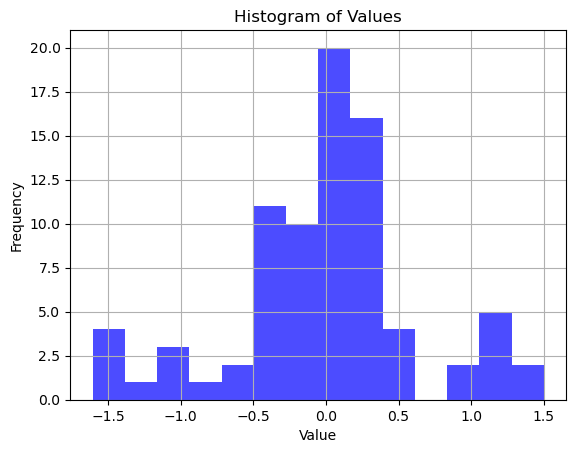

In [17]:
params = lr_model.coef_.reshape(*input_window_shape)
plot_histogram(params.flatten())

In [18]:
ratio = 0.95

param_truncated, threshold = zero_smallest_absolute_to_meet_ratio(params, ratio)
print(f"threshold = {threshold}")
print(f"zeros: {int(np.sum(param_truncated == 0))}")
print(f"non-zeros: {int(np.sum(param_truncated != 0))}")

threshold = 0.15402274578810707
zeros: 25
non-zeros: 56
